<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/ModelRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install firebase-admin
import firebase_admin
import cv2 
from firebase_admin import credentials,db 
from google.colab.patches import cv2_imshow
from sklearn.externals import joblib 
from firebase_admin import storage 
import pandas as pd 
import csv 
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
cred = credentials.Certificate("credentials.json")

# Initialize the app with a service account, granting admin privileges
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'fir-4ca2c.appspot.com',
}, name='storage')

IMAGE GENERATION 

In [7]:
##GETTING NAMES  -- ##Location - SSCB and DTU : Rotated images  

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

#blobs is an interator :google.api_core.page_iterator.HTTPIterator object at 0x7f2cd11c84e0>

imglenovo = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="lenovoinS" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      imglenovo.append("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg') 
      print("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
     
      
    

lenovo2019-06-27 17:05:48.jpeg
lenovo2019-06-27 17:10:27.jpeg
lenovo2019-06-27 17:15:58.jpeg
lenovo2019-06-27 18:04:29.jpeg
lenovo2019-06-27 18:08:53.jpeg
lenovo2019-06-27 18:17:05.jpeg
lenovo2019-06-27 18:19:07.jpeg
lenovo2019-06-27 18:26:07.jpeg
lenovo2019-06-27 18:28:53.jpeg
lenovo2019-06-27 18:35:27.jpeg
lenovo2019-06-27 18:39:31.jpeg
lenovo2019-06-27 18:47:06.jpeg
lenovo2019-06-27 18:49:07.jpeg
lenovo2019-06-27 18:56:06.jpeg
lenovo2019-06-28 06:00:07.jpeg
lenovo2019-06-28 06:04:07.jpeg
lenovo2019-06-28 06:09:28.jpeg
lenovo2019-06-28 06:14:37.jpeg
lenovo2019-06-28 06:18:53.jpeg
lenovo2019-06-28 06:25:28.jpeg
lenovo2019-06-28 06:29:29.jpeg
lenovo2019-06-28 06:35:27.jpeg
lenovo2019-06-28 06:38:53.jpeg
lenovo2019-06-28 06:44:28.jpeg
lenovo2019-06-28 06:49:29.jpeg
lenovo2019-06-28 06:56:37.jpeg
lenovo2019-06-28 07:00:28.jpeg
lenovo2019-06-28 07:04:07.jpeg
lenovo2019-06-28 07:09:28.jpeg
lenovo2019-06-28 07:13:53.jpeg
lenovo2019-06-28 07:18:53.jpeg
lenovo2019-06-28 07:23:53.jpeg
lenovo20

In [0]:
##READING THEM 

dtu=[]
sscb=[]
for img in imglenovo:
  if(img[11:16]>'07-02'):##These indicate the DTU Images - which need to be cropped and rotated 
    l=[]
    l.append(img)
    im = cv2.imread(img)
    crop = im[700:3150, 0:3120]
    crop = cv2.resize(crop, (int(np.shape(im)[1]*0.1), int(np.shape(im)[0]*0.1)))
    im = cv2.resize(crop,(256,256))
    im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    dtu.append(l)
  else:
    l=[]
    l.append(img)
    im = cv2.imread(img)           ##These indicate the SSCB Images - rotation only 
    im = cv2.resize(im, (256,256))
    im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_CLOCKWISE)
    l.append(im)
    sscb.append(l)
    
    
    

In [9]:
## CHECKING BLOCK 

print(len(dtu))
print(len(sscb))


369
502


In [10]:
##GETTING NAMES - PUNJABI BAGH 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgpb = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name.split('/')[1]=="rivers.jpg" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgpb.append("pb" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        

pb2019-07-03 12:46:45.jpeg
pb2019-07-03 12:47:33.jpeg
pb2019-07-03 12:48:16.jpeg
pb2019-07-03 12:49:38.jpeg
pb2019-07-03 12:50:40.jpeg
pb2019-07-03 12:51:46.jpeg
pb2019-07-03 12:52:29.jpeg
pb2019-07-03 12:53:54.jpeg
pb2019-07-03 12:54:57.jpeg
pb2019-07-03 12:56:00.jpeg
pb2019-07-03 12:57:00.jpeg
pb2019-07-03 12:58:01.jpeg
pb2019-07-03 12:58:16.jpeg
pb2019-07-03 12:59:16.jpeg
pb2019-07-03 13:01:35.jpeg
pb2019-07-03 13:02:57.jpeg
pb2019-07-03 13:03:59.jpeg
pb2019-07-03 13:04:14.jpeg
pb2019-07-03 13:05:00.jpeg
pb2019-07-03 13:05:27.jpeg
pb2019-07-03 13:06:00.jpeg
pb2019-07-03 13:06:42.jpeg
pb2019-07-03 13:08:00.jpeg
pb2019-07-03 13:08:58.jpeg
pb2019-07-03 13:10:17.jpeg
pb2019-07-03 13:11:18.jpeg
pb2019-07-03 13:12:19.jpeg
pb2019-07-03 13:13:35.jpeg
pb2019-07-03 13:14:22.jpeg
pb2019-07-03 13:15:24.jpeg
pb2019-07-03 13:16:25.jpeg
pb2019-07-03 13:17:26.jpeg
pb2019-07-03 13:18:21.jpeg
pb2019-07-03 13:19:27.jpeg
pb2019-07-03 13:20:27.jpeg
pb2019-07-03 13:21:27.jpeg
pb2019-07-03 13:22:28.jpeg
p

In [0]:
##READING IMAGES - Rotated

pb=[]
for img in imgpb:
  l=[]
  l.append(img)
  im = cv2.imread(img)
  im = cv2.resize(im, (256,256))
  im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_CLOCKWISE)
  l.append(im)
  pb.append(l)


In [12]:
##GETTING NAMES - Location : DTU AND SHADIPUR 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgminote = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="minoteSSC" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgminote.append("minote" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        
      


minote2019-06-27 16:42:56.jpeg
minote2019-06-27 16:49:53.jpeg
minote2019-06-27 16:50:47.jpeg
minote2019-06-27 16:51:15.jpeg
minote2019-06-27 16:54:37.jpeg
minote2019-06-27 16:59:33.jpeg
minote2019-06-27 17:04:38.jpeg
minote2019-06-27 17:05:00.jpeg
minote2019-06-27 17:09:17.jpeg
minote2019-06-27 17:14:39.jpeg
minote2019-06-27 17:19:17.jpeg
minote2019-06-27 17:24:39.jpeg
minote2019-06-27 17:29:17.jpeg
minote2019-06-27 17:37:58.jpeg
minote2019-06-27 17:39:17.jpeg
minote2019-06-27 17:46:28.jpeg
minote2019-06-27 17:49:20.jpeg
minote2019-06-27 17:54:17.jpeg
minote2019-06-27 18:01:16.jpeg
minote2019-06-27 18:05:04.jpeg
minote2019-06-27 18:09:35.jpeg
minote2019-06-27 18:14:59.jpeg
minote2019-06-27 18:19:18.jpeg
minote2019-06-27 18:24:40.jpeg
minote2019-06-27 18:29:18.jpeg
minote2019-06-27 18:35:06.jpeg
minote2019-06-27 18:39:38.jpeg
minote2019-06-27 18:47:35.jpeg
minote2019-06-27 18:49:17.jpeg
minote2019-06-27 18:54:39.jpeg
minote2019-06-27 18:59:28.jpeg
minote2019-06-28 06:02:35.jpeg
minote20

In [0]:
##READING IMAGES - Location - SSCB and SHADIPUR ; Rotation 
shadipur = []
for img in imgminote : 
  if(img[11:16]>'07-05'):  ##Shadipur images needed rotating  
    l=[]
    l.append(img)
    im = cv2.imread(img)
    im = cv2.resize(im, (256,256))
    im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    shadipur.append(l)
  else:
    l=[]
    l.append(img)
    im = cv2.imread(img)               ##SSCB images did not need any rotating 
    im = cv2.resize(im, (256,256))
    l.append(im)
    sscb.append(l)
    

In [14]:
print(len(shadipur))
print(len(sscb))

244
1320


In [15]:
##READING BLOCK 
'''
ito=[]

for img in imgito:
  l=[]
  l.append(img)
  im = cv2.imread(img)
  im = cv2.resize(im,(256,256))
  im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)
  l.append(im)
  ito.append(l)
 '''

'\nito=[]\n\nfor img in imgito:\n  l=[]\n  l.append(img)\n  im = cv2.imread(img)\n  im = cv2.resize(im,(256,256))\n  im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)\n  l.append(im)\n  ito.append(l)\n '

In [0]:
##CHECKING BLOCK 

# cv2_imshow(ito[0])
# cv2_imshow(ito[100])


In [16]:
print(np.shape(sscb))    
#print(np.shape(ito))      
print(np.shape(dtu))  
print(np.shape(shadipur))     
print(np.shape(pb))     



(1320, 2)
(369, 2)
(244, 2)
(483, 2)


LABEL PROCESSING 

In [0]:
##SSCB 
df = pd.read_csv('/content/sscb_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/sscb_labels_new.csv')

k=0
cpcb=[]

with open('/content/sscb_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [100]:
print(len(cpcb))

698


In [0]:
##TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in sscb:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)  
  
  

In [102]:
feat=[]
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      #l.append(transmission(im,retMean=True))
      imc = date[2]
      imc = cv2.resize(imc, (64,64))
      l.append(np.ndarray.flatten(transmission(imc,retMean = False)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)
      
   

minote2019-06-27 16:54:37.jpeg
   -   -  ['27-06-2019 16:00', array([0.61904762, 0.66666667, 0.71428571, ..., 0.71428571, 0.66666667,
       0.66666667]), 5.071457862854004, 2.468056791148552, '47']
minote2019-06-27 16:59:33.jpeg
   -   -  ['27-06-2019 16:00', array([0.67611336, 0.67611336, 0.67611336, ..., 0.89473684, 0.92307692,
       0.92307692]), 40.19698715209961, 59.820981855775706, '47']
minote2019-06-27 16:42:56.jpeg
   -   -  ['27-06-2019 16:45', array([0.26556017, 0.26556017, 0.26556017, ..., 0.89211618, 0.89211618,
       0.89211618]), 41.98408126831055, 60.822207739303735, '47']
minote2019-06-27 16:49:53.jpeg
   -   -  ['27-06-2019 16:45', array([0.65, 0.65, 0.65, ..., 0.6 , 0.6 , 0.6 ]), 5.048366069793701, 2.470456806162675, '47']
minote2019-06-27 16:50:47.jpeg
   -   -  ['27-06-2019 16:45', array([0.86695279, 0.86695279, 0.86695279, ..., 0.87553648, 0.87982833,
       0.87982833]), 42.25675964355469, 62.17865647994067, '47']
minote2019-06-27 16:51:15.jpeg
   -   -  ['27-

In [103]:
print(len(feat))

1157


In [0]:

df = pd.read_csv('/content/dtu_labels.csv')

data = df.mask(df.eq('None')).dropna()

file = data.to_csv('/content/dtu_labels_new.csv')

k=0

cpcb=[]

with open('/content/dtu_labels_new.csv') as file:

  reader = csv.reader(file, delimiter =',')

  for row in reader:

    k+=1

    if(k>3):

      l=[]

      l.append(row[1]) #DATE 

      l.append(row[3]) #PM

      cpcb.append(l) 

In [0]:
##TIMESTAMP MODIFICATION 


m_tmp=[]
for tmp in dtu:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)  
  

In [106]:
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
      imc = date[2]
      imc = cv2.resize(imc, (64,64))
      l.append(val[0])
      #l.append(transmission(im,retMean=True))
      l.append(np.ndarray.flatten(transmission(imc,retMean = False)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)
      

lenovo2019-07-03 16:54:58.jpeg
   -   -  ['03-07-2019 16:00', array([0.41960784, 0.41960784, 0.41960784, ..., 0.98431373, 0.98039216,
       0.98039216]), 43.94867706298828, 86.06920885429538, '28.14']
lenovo2019-07-03 16:09:45.jpeg
   -   -  ['03-07-2019 16:15', array([0.43921569, 0.43921569, 0.43921569, ..., 0.98431373, 0.98431373,
       0.98431373]), 44.03278732299805, 85.93560556766379, '29.15']
lenovo2019-07-03 16:14:59.jpeg
   -   -  ['03-07-2019 16:15', array([0.45882353, 0.47058824, 0.47058824, ..., 0.98823529, 0.98823529,
       0.98431373]), 46.8581428527832, 83.35990418815406, '29.15']
lenovo2019-07-03 16:20:22.jpeg
   -   -  ['03-07-2019 16:15', array([0.51372549, 0.51372549, 0.48627451, ..., 0.98823529, 0.98431373,
       0.98431373]), 47.97339630126953, 81.99809791194996, '29.15']
lenovo2019-07-03 16:25:16.jpeg
   -   -  ['03-07-2019 16:30', array([0.49019608, 0.49019608, 0.48627451, ..., 0.98039216, 0.98039216,
       0.98039216]), 48.050804138183594, 82.01107310915145,

In [107]:
print(len(feat))

1526


In [0]:
## PUNJABI BAGH 

df = pd.read_csv('/content/pb_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/labels_pb_new.csv')


k=0
cpcb=[]

with open('/content/labels_pb_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [0]:
##TIMESTAMP MODIFICATION 

m_tmp=[]
for tmp in pb:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)   

In [110]:
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      imc = date[2]
      imc = cv2.resize(imc,(64,64))
      #l.append(transmission(im,retMean=True))
      l.append(np.ndarray.flatten(transmission(imc,retMean = False)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)

pb2019-07-03 12:53:54.jpeg
   -   -  ['03-07-2019 12:00', array([0.23744292, 0.23744292, 0.19634703, ..., 0.67123288, 0.97260274,
       0.97260274]), 43.27198028564453, 71.79568436486677, '48.3']
pb2019-07-03 12:54:57.jpeg
   -   -  ['03-07-2019 12:00', array([0.20535714, 0.20535714, 0.17857143, ..., 0.69196429, 0.99107143,
       0.99107143]), 44.84650421142578, 73.70845157017446, '48.3']
pb2019-07-03 12:56:00.jpeg
   -   -  ['03-07-2019 12:00', array([0.20627803, 0.20627803, 0.1793722 , ..., 0.73991031, 0.97757848,
       0.97757848]), 45.55087661743164, 73.23119520079827, '48.3']
pb2019-07-03 12:57:00.jpeg
   -   -  ['03-07-2019 12:00', array([0.20179372, 0.20179372, 0.1838565 , ..., 0.69506726, 0.98206278,
       0.98206278]), 44.28897476196289, 71.77747304691782, '48.3']
pb2019-07-03 12:58:01.jpeg
   -   -  ['03-07-2019 12:00', array([0.2       , 0.2       , 0.17727273, ..., 0.67727273, 0.98181818,
       0.98181818]), 43.99489212036133, 71.24182355357836, '48.3']
pb2019-07-03 12

In [111]:
print(len(feat))

2009


In [112]:
## ITO 
'''df_ = pd.read_csv('/content/ito_labels.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/ito_labels_new.csv')


k=0
cpcb=[]

with open('/content/ito_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) '''

"df_ = pd.read_csv('/content/ito_labels.csv')\ndata_ = df_.mask(df_.eq('None')).dropna()\nfile_ = data_.to_csv('/content/ito_labels_new.csv')\n\n\nk=0\ncpcb=[]\n\nwith open('/content/ito_labels_new.csv') as file:\n  reader = csv.reader(file, delimiter =',')\n  for row in reader:\n    k+=1\n    if(k>3):\n      l=[]\n      l.append(row[1]) #DATE \n      l.append(row[3]) #PM\n      cpcb.append(l) "

In [113]:
##TIMESTAMP MODIFICATION 
'''m_tmp=[]
for tmp in ito:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l) '''

"m_tmp=[]\nfor tmp in ito:\n  l=[]\n  temp=tmp[0]\n  temp=temp[-24:-5]\n  temp=temp.split('-')\n  newtemp=temp[2].split(' ')\n  newesttemp=newtemp[1].split(':')\n  j=int(newesttemp[1])\n  #print(j)\n  if(j<=7.5):\n    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'\n  elif(j<=15 or j<=22.5):\n    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'\n  elif(j<=30 or j<=37.5):\n    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'\n  elif(j<=45 or j<=52.5):\n    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'\n  elif(j>52.5):\n    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'\n  l.append(tmp[0])\n  l.append(final)\n  l.append(tmp[1])\n  m_tmp.append(l) "

In [114]:
'''for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      #l.append(transmission(im,retMean=True))
      l.append(np.ndarray.flatten(transmission(im,retMean = False)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)'''

"for val in cpcb:\n  for date in m_tmp:\n    if(val[0] == date[1]):\n      print(date[0])\n      im = date[2]\n      l=[]\n      l.append(val[0])\n      #l.append(transmission(im,retMean=True))\n      l.append(np.ndarray.flatten(transmission(im,retMean = False)))\n      l.append(entropy(im))\n      l.append(contrast(im))\n      l.append(val[1])\n      print('   -   -  ' + str(l))\n      feat.append(l)"

In [115]:
print(len(feat))

2009


In [0]:
## SHADIPUR 

df_ = pd.read_csv('/content/shadipur_labels.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/shadipur_labels_new.csv')


k=0
cpcb=[]

with open('/content/shadipur_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [117]:
print(len(cpcb))

418


In [0]:

##TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in shadipur:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l) 
 

In [119]:

for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      imc = date[2]
      imc = cv2.resize(imc, (64,64))
      #l.append(transmission(im,retMean=True))
      l.append(np.ndarray.flatten(transmission(imc,retMean = False)))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      print('   -   -  ' + str(l))
      feat.append(l)

minote2019-07-06 06:02:51.jpeg
   -   -  ['06-07-2019 06:00', array([0.66798419, 0.66798419, 0.44268775, ..., 0.77470356, 0.79841897,
       0.79841897]), 51.09196472167969, 79.54891514830013, '65.12']
minote2019-07-06 06:56:50.jpeg
   -   -  ['06-07-2019 06:00', array([0.716, 0.716, 0.484, ..., 0.78 , 0.812, 0.812]), 51.513912200927734, 78.68497408220485, '65.12']
minote2019-07-06 06:08:02.jpeg
   -   -  ['06-07-2019 06:15', array([0.65873016, 0.65873016, 0.48015873, ..., 0.76587302, 0.80555556,
       0.80555556]), 50.78607177734375, 79.7805814016487, '66.88']
minote2019-07-06 06:12:35.jpeg
   -   -  ['06-07-2019 06:15', array([0.66666667, 0.66666667, 0.44578313, ..., 0.78313253, 0.81124498,
       0.81124498]), 49.60020446777344, 79.15512153350036, '66.88']
minote2019-07-06 06:16:49.jpeg
   -   -  ['06-07-2019 06:15', array([0.648, 0.648, 0.544, ..., 0.776, 0.776, 0.776]), 49.743465423583984, 78.35325558384844, '66.88']
minote2019-07-06 06:22:35.jpeg
   -   -  ['06-07-2019 06:15', a

In [120]:
print(len(feat))

2253


WEATHER DATA 

In [0]:
cred = credentials.Certificate('credentials.json')

# Initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://fir-4ca2c.firebaseio.com/'
})

In [0]:
    
ref = db.reference()
df = ref.get()


In [122]:
temp_weather = {}

for key in df:
  try:
    l=[]
    l.append(df[key]['main']['humidity'])
    l.append(df[key]['main']['pressure'])
    l.append(df[key]['main']['temp'])
    l.append(df[key]['visibility'])
    l.append(df[key]['wind']['deg'])
    l.append(df[key]['wind']['speed'])
    l.append(df[key]['clouds']['all'])
    k = df[key]['weather'][0]['description']
    if(k=='haze'):
      l.append(0)
    elif(k=='mist'):
      l.append(1)
    elif(k=='drizzle'):
      l.append(2)
    elif(k=='dust'):
      l.append(3)
    temp_weather[key]=l
  except:
    print(key)

08-07-2019 02:52:50
08-07-2019 02:57:50
13-07-2019 12:43:49


In [0]:
weather={}
for key in temp_weather:
  temp=key.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  if(j<=7.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  if(final not in weather):
    weather[final]=temp_weather[key]
  
  

In [127]:
print(np.ndarray.flatten(feat[0][1]))

[0.61904762 0.66666667 0.71428571 ... 0.71428571 0.66666667 0.66666667]


In [0]:
hours=[]
hum=[]
pressure=[]
temp=[]
vis=[]
deg=[]
speed=[]
cc=[]
desc=[]
trans=[]
cont=[]
ent=[]
pm=[]


for e in feat:
  hours.append(float(e[0][-5:-3]))
  pm.append(float(e[4]))
  trans.append(e[1])
  ent.append(float(e[2]))
  cont.append(float(e[3]))
  for w in weather:                                      ##Matching weather data 
    if(e[0] == w):
      hum.append(weather[w][0])
      pressure.append(weather[w][1])
      temp.append(weather[w][2]) 
      vis.append(weather[w][3])
      deg.append(weather[w][4])
      speed.append(weather[w][5])
      cc.append(weather[w][6])
      try:
        desc.append(weather[w][7])
      except:
        #print(e[0])
        desc.append(0)
    
 


In [0]:
##Adding ITO's data 

In [129]:
print(len(hours))
print(hours)
print(len(trans))
print(len(cont))

print(speed)
print(len(cc))
print(cc)
print(len(desc))
print(desc)


##with ITO - 2752 

2253
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 

In [131]:
final_shape=len(hours)

#FEATURES 

hours = np.reshape(hours,(final_shape,1))
cont = np.reshape(cont,(final_shape,1))
ent = np.reshape(ent,(final_shape,1))
hum = np.reshape(hum,(final_shape,1))
pressure = np.reshape(pressure,(final_shape,1))
temp = np.reshape(temp,(final_shape,1))
vis = np.reshape(vis,(final_shape,1))
deg = np.reshape(deg,(final_shape,1))
speed = np.reshape(speed,(final_shape,1))
cc = np.reshape(cc,(final_shape,1))
desc = np.reshape(desc,(final_shape,1))

#LABEL
pm = np.reshape(pm,(final_shape,1))

s1 = MinMaxScaler()
hours = s1.fit_transform(hours)

s2 = MinMaxScaler()
cont = s2.fit_transform(cont)

s3 = MinMaxScaler()
ent = s3.fit_transform(ent)

s4 = MinMaxScaler()
hum = s4.fit_transform(hum)

s5 = MinMaxScaler()
pressure = s5.fit_transform(pressure)

s6 = MinMaxScaler()
temp = s6.fit_transform(temp)

s7 = MinMaxScaler()
vis = s7.fit_transform(vis)

s8 = MinMaxScaler()
deg = s8.fit_transform(deg)

s9 = MinMaxScaler()
speed = s9.fit_transform(speed)

s10 = MinMaxScaler()
cc = s10.fit_transform(cc)

s11 = MinMaxScaler()
des = s11.fit_transform(desc)


joblib.dump(s1,'S1.pkl')
joblib.dump(s2,'S2.pkl')
joblib.dump(s3,'S3.pkl')
joblib.dump(s4,'S4.pkl')
joblib.dump(s5,'S5.pkl')
joblib.dump(s6,'S6.pkl')
joblib.dump(s7,'S7.pkl')
joblib.dump(s8,'S8.pkl')
joblib.dump(s9,'S9.pkl')
joblib.dump(s10,'S10.pkl')
joblib.dump(s11,'S11.pkl')

features = np.hstack((hours, cont, ent, hum, temp, vis, deg, speed,cc, desc,pressure,trans))

print(len(features[5]))

4107


In [0]:
joblib.dump(features, '/content/features_w.pkl')
joblib.dump(pm, '/content/labels.pkl')

['/content/labels.pkl']

In [0]:
print(len(pm))

2253


In [0]:
print(np.shape(features[0]))

(11,)


18.808749202898966


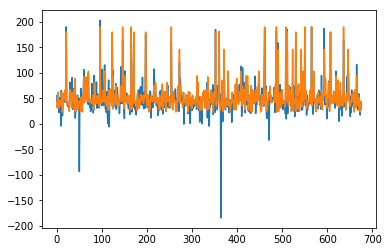

In [132]:
lineareg = LinearRegression(normalize =False)
cross = cross_val_score(lineareg, features, pm, scoring ='neg_mean_squared_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.3, random_state =42)

lineareg.fit(x_train, y_train)

pred = lineareg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)


#(500 IMAGES LESS THAN WITH THE PREVIOUS REGRESSOR !!!!! )


In [133]:
joblib.dump(lineareg,'LINEAR_reg_WITH_TRANS.pkl')



['LINEAR_reg_WITH_TRANS.pkl']

In [134]:
print(((-1)*cross)**0.5)

[ 81.76635351  44.54480013 194.60566044]


In [0]:
d=[]
for i in range(0,len(pred)):
  print(str(y_test[i]) +'\t'+ str(pred[i]))
  k=y_test[i]-pred[i]
  if(k<=20 and k>=-20):
    d.append(k)


In [0]:
plt.plot(d)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_trai

13.85218768149857


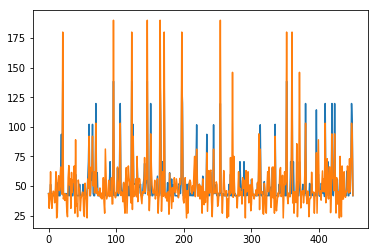

In [0]:
reg = RandomForestRegressor(max_depth=3) 
cross = cross_val_score(reg, features, pm, scoring ='neg_mean_squared_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

reg.fit(x_train, y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)


In [0]:
print(((-1)*cross)**0.5)

[43.57905835 32.48231489  9.84212112]


In [0]:
joblib.dump(reg,'AQImodelRandom_withouttrans.pkl')



['AQImodelRandom_withouttrans.pkl']

In [0]:
'''##GETTING NAMES - ITO  ## DONT RUN RIGHT NOW AS THERE IS NO WEATHER DATA FOR THIS 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgito = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name.split('/')[1]=="Lenovo.JPG" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "ito" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgito.append("ito" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("ito" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        
        
'''        

'##GETTING NAMES - ITO  ## DONT RUN RIGHT NOW AS THERE IS NO WEATHER DATA FOR THIS \n\nbucket = storage.bucket(app=app)\nblobs = bucket.list_blobs()\n\nimgito = [] #has all the minote pictures by their name \nctr=0\nmits = set()\nfor blob in blobs:\n  if blob.name.split(\'/\')[1]=="Lenovo.JPG" :\n    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:\n        blob.download_to_filename(\'/content/\' + "ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\')\n        imgito.append("ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\') \n        print("ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\')\n        ctr+=1\n        \n        \n'

In [0]:

for i in range(0,len(pred)):
  print(str(y_test[i]) +'\t'+ str(pred[i]))
  
  

In [0]:
def transmission(img, lt = 230, retMean = False):
  ker = np.ones((3, 3))/9.0
  imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  b, g, r = cv2.split(img)
  hsv = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2HSV)
  _, _, v = cv2.split(hsv)
  v_blur = cv2.filter2D(v, -1, ker)
  _,building_mask = cv2.threshold(v_blur, lt, 255, cv2.THRESH_BINARY)
  sky = cv2.bitwise_and(imgrgb, imgrgb, mask = building_mask)
  sky_mask = cv2.bitwise_not(building_mask, building_mask.copy())
  building = cv2.bitwise_and(imgrgb, imgrgb, mask = sky_mask)
 
  al = max(v_blur.flatten())
  #Airlight Found. Now calculate Transmission Map
  img_norm = img/float(al)
  b, g, r = cv2.split(img_norm)
  kernel = np.ones((3,3),np.uint8)
  im_new = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      im_new[i][j] = min(b[i][j], g[i][j], r[i][j])
  dcp = cv2.erode(im_new, kernel, iterations = 1)
  #ax[3].imshow(im_new, cmap = 'gray')
  #ax[4].imshow(dcp, cmap = 'gray')
  tr = np.ones((dcp.shape[0], dcp.shape[1]))
  for i in range(dcp.shape[0]):
    for j in range(dcp.shape[1]):
      tr[i][j] = 1 - dcp[i][j]
  #ax[1].imshow(tr, cmap = 'gray')
  if retMean == False:
    return tr
  elif retMean == True:
    return np.mean(tr)

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120)

cross = cross_val_score(gbrt, features, pm, scoring ='neg_mean_squared_error',cv=3)

x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

gbrt.fit(x_train, y_train)

y_pred = gbrt.predict(x_test)

errors = [mean_squared_error(y_val, y_pred)
for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(x_train, y_train) 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [0]:
print((cross*(-1))**0.5)

In [0]:
pred = gbrt_best.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)

In [0]:
pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)

In [0]:
print(((-1)*cross)**0.5)